<div style="width: 100%; margin: 0 auto;">
    <a href="https://github.com/e10101/learning-artificial-intelligence">
        <img src="../../assets/banner.svg" alt="Learning Operations Research" style="width: 100%; height: auto; display: block;">
    </a>
</div>

# Ollama Embedding Demos

[![Github](../../assets/badges/github.svg)](https://github.com/e10101/learning-artificial-intelligence)

## Ollama

Pull images, for example [ZimaBlueAI/Qwen3-Embedding-0.6B:Q8_0](https://ollama.com/ZimaBlueAI/Qwen3-Embedding-0.6B).

```shell
ollama pull ZimaBlueAI/Qwen3-Embedding-0.6B:Q8_0
```

For example, output:

```plaintext
ollama pull ZimaBlueAI/Qwen3-Embedding-0.6B:Q8_0
pulling manifest 
pulling a0e820fb3f8f: 100% ▕███████████████████████████████████████████████████████████▏ 639 MB                         
pulling ae370d884f10: 100% ▕███████████████████████████████████████████████████████████▏ 1.7 KB                         
pulling a4d6722ad13e: 100% ▕███████████████████████████████████████████████████████████▏  109 B                         
pulling d18a5cc71b84: 100% ▕███████████████████████████████████████████████████████████▏  11 KB                         
pulling 9a80b68a60aa: 100% ▕███████████████████████████████████████████████████████████▏  193 B                         
verifying sha256 digest 
writing manifest 
success 
```

Check model info:

```shell
curl http://localhost:11434/api/show -d '{
  "model": "ZimaBlueAI/Qwen3-Embedding-0.6B:Q8_0"
}'
```

Request embedding:

```shell
curl http://localhost:11434/api/embed -d '{
  "model": "ZimaBlueAI/Qwen3-Embedding-0.6B:Q8_0",
  "input": "Why is the sky blue?"
}'
```


In [2]:
import json
import requests
import numpy as np
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import pandas as pd

In [3]:
# OLLAMA_API_BASE = "http://localhost:11434"
OLLAMA_API_BASE = "http://host.docker.internal:11434" # Inside Docker container
MODEL_NAME = "ZimaBlueAI/Qwen3-Embedding-0.6B:Q8_0"

In [6]:
class LocalEmbeddingDemo:
    def __init__(self, model_name: str = MODEL_NAME, api_base: str = OLLAMA_API_BASE):
        self.model_name = model_name
        self.api_base = api_base
        self.embeddings_cache = {}
        
    def get_embedding(self, text: str) -> List[float]:
        """Get embedding vector for text"""
        if text in self.embeddings_cache:
            return self.embeddings_cache[text]
            
        try:
            response = requests.post(
                f"{self.api_base}/api/embed",
                json={
                    "model": self.model_name,
                    "input": text
                },
                timeout=30
            )
            response.raise_for_status()
            embedding = response.json()["embeddings"][0]
            self.embeddings_cache[text] = embedding
            return embedding
        except Exception as e:
            print(f"Failed to get embedding: {e}")
            return []
    
    def calculate_similarity(self, text1: str, text2: str) -> float:
        """Calculate cosine similarity between two texts"""
        emb1 = np.array(self.get_embedding(text1)).reshape(1, -1)
        emb2 = np.array(self.get_embedding(text2)).reshape(1, -1)
        
        if emb1.size == 0 or emb2.size == 0:
            return 0.0
            
        similarity = cosine_similarity(emb1, emb2)[0][0]
        return float(similarity)
    
    def batch_similarity(self, texts: List[str]) -> np.ndarray:
        """Calculate similarity matrix for a batch of texts"""
        embeddings = []
        for text in texts:
            emb = self.get_embedding(text)
            if emb:
                embeddings.append(emb)
            else:
                embeddings.append([0] * 512)  # Default dimension
        
        embeddings = np.array(embeddings)
        similarity_matrix = cosine_similarity(embeddings)
        return similarity_matrix
    
    def visualize_similarity_matrix(self, texts: List[str], title: str = "Text Similarity Matrix"):
        """Visualize similarity matrix"""
        similarity_matrix = self.batch_similarity(texts)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            similarity_matrix,
            annot=True,
            fmt='.3f',
            xticklabels=[f"Text{i+1}" for i in range(len(texts))],
            yticklabels=[f"Text{i+1}" for i in range(len(texts))],
            cmap='coolwarm',
            center=0
        )
        plt.title(title)
        plt.tight_layout()
        plt.show()
        
        # Print detailed information
        print(f"\n{title}:")
        for i, text in enumerate(texts):
            print(f"Text{i+1}: {text}")
        print()
    
    def semantic_search(self, query: str, documents: List[str], top_k: int = 5) -> List[Tuple[str, float]]:
        """Semantic search demonstration"""
        query_emb = np.array(self.get_embedding(query)).reshape(1, -1)
        
        results = []
        for doc in documents:
            doc_emb = np.array(self.get_embedding(doc)).reshape(1, -1)
            if query_emb.size > 0 and doc_emb.size > 0:
                similarity = cosine_similarity(query_emb, doc_emb)[0][0]
                results.append((doc, float(similarity)))
        
        results.sort(key=lambda x: x[1], reverse=True)
        return results[:top_k]
    
    def visualize_embeddings_2d(self, texts: List[str], title: str = "Text Embedding 2D Visualization"):
        """Reduce embeddings to 2D and visualize"""
        embeddings = []
        valid_texts = []
        
        for text in texts:
            emb = self.get_embedding(text)
            if emb:
                embeddings.append(emb)
                valid_texts.append(text)
        
        if len(embeddings) < 2:
            print("Need at least 2 valid embeddings for visualization")
            return
        
        embeddings = np.array(embeddings)
        
        # Use PCA to reduce to 2D
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                            c=range(len(valid_texts)), cmap='tab10', s=100)
        
        # Add text labels
        for i, (x, y) in enumerate(embeddings_2d):
            plt.annotate(f"{i+1}", (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=12)
        
        plt.title(title)
        plt.xlabel(f'PC1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'PC2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
        plt.grid(True, alpha=0.3)
        
        # Add legend
        for i, text in enumerate(valid_texts):
            print(f"{i+1}: {text}")
        
        plt.tight_layout()
        plt.show()

## Check Service Status

In [11]:
try:
    response = requests.get(f"{OLLAMA_API_BASE}/api/tags", timeout=5)
    if response.status_code == 200:
        print("✓ Ollama service is running normally")
    else:
        print("✗ Ollama service connection failed")
except Exception as e:
    print(f"✗ Cannot connect to Ollama service: {e}")
    print("Please ensure to run: ollama serve")


✓ Ollama service is running normally


## Basic Similarity Demostration

In [8]:
def demo_basic_similarity():
    """Basic similarity demonstration"""
    print("=" * 60)
    print("Basic Text Similarity Demo")
    print("=" * 60)
    
    demo = LocalEmbeddingDemo()
    
    # Test text pairs
    text_pairs = [
        ("The weather is nice today", "Today is sunny and bright"),
        ("I like eating apples", "Apples are my favorite fruit"),
        ("Machine learning is interesting", "Deep learning algorithms are complex"),
        ("The weather is nice today", "I love programming"),
        ("Artificial intelligence", "AI technology")
    ]
    
    for text1, text2 in text_pairs:
        similarity = demo.calculate_similarity(text1, text2)
        print(f"Text1: {text1}")
        print(f"Text2: {text2}")
        print(f"Similarity: {similarity:.4f}")
        print("-" * 40)

In [9]:
demo_basic_similarity()

Basic Text Similarity Demo
Text1: The weather is nice today
Text2: Today is sunny and bright
Similarity: 0.5101
----------------------------------------
Text1: I like eating apples
Text2: Apples are my favorite fruit
Similarity: 0.6991
----------------------------------------
Text1: Machine learning is interesting
Text2: Deep learning algorithms are complex
Similarity: 0.5278
----------------------------------------
Text1: The weather is nice today
Text2: I love programming
Similarity: 0.2896
----------------------------------------
Text1: Artificial intelligence
Text2: AI technology
Similarity: 0.8365
----------------------------------------


## Similarity Matrix Demonstration

In [25]:
def demo_similarity_matrix(texts=None):
    """Similarity matrix demonstration"""
    print("=" * 60)
    print("Similarity Matrix Visualization Demo")
    print("=" * 60)
    
    demo = LocalEmbeddingDemo()
    
    # Different topic texts
    if texts is None:
        texts = [
            "The weather is nice today, sunny and bright",
            "The sky is clear, perfect for going out",
            "I like machine learning",
            "Deep learning is interesting",
            "Artificial intelligence changes the world",
            "Apples taste good",
            "Fruits are nutritious",
            "Programming is an art"
        ]
    
    demo.visualize_similarity_matrix(texts)

Similarity Matrix Visualization Demo


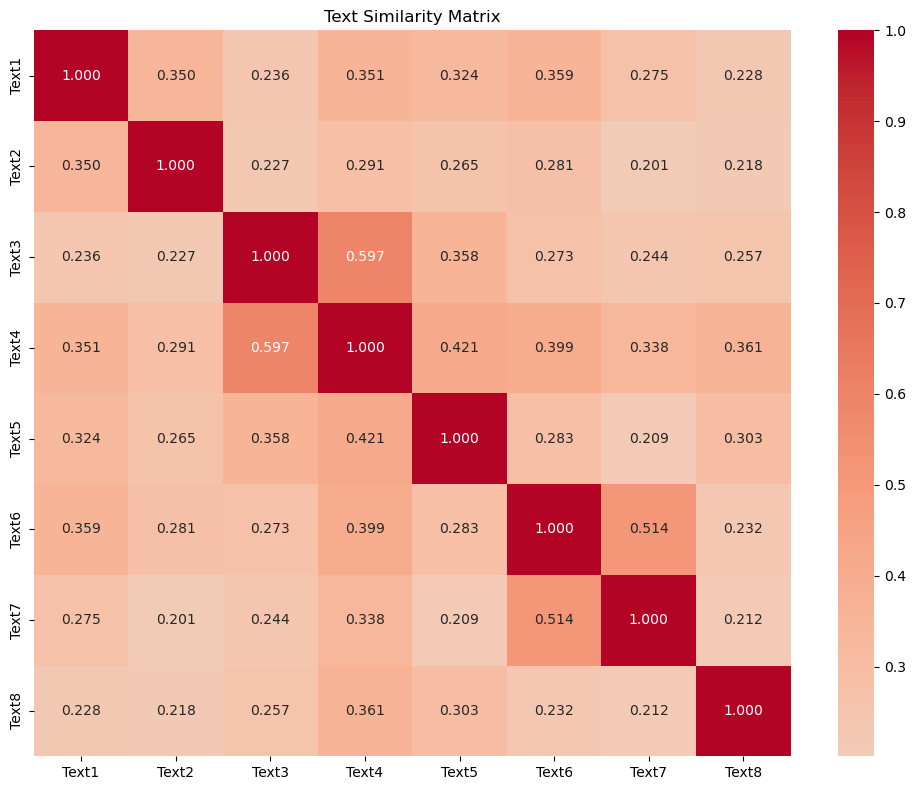


Text Similarity Matrix:
Text1: The weather is nice today, sunny and bright
Text2: The sky is clear, perfect for going out
Text3: I like machine learning
Text4: Deep learning is interesting
Text5: Artificial intelligence changes the world
Text6: Apples taste good
Text7: Fruits are nutritious
Text8: Programming is an art



In [26]:
demo_similarity_matrix()

Similarity Matrix Visualization Demo


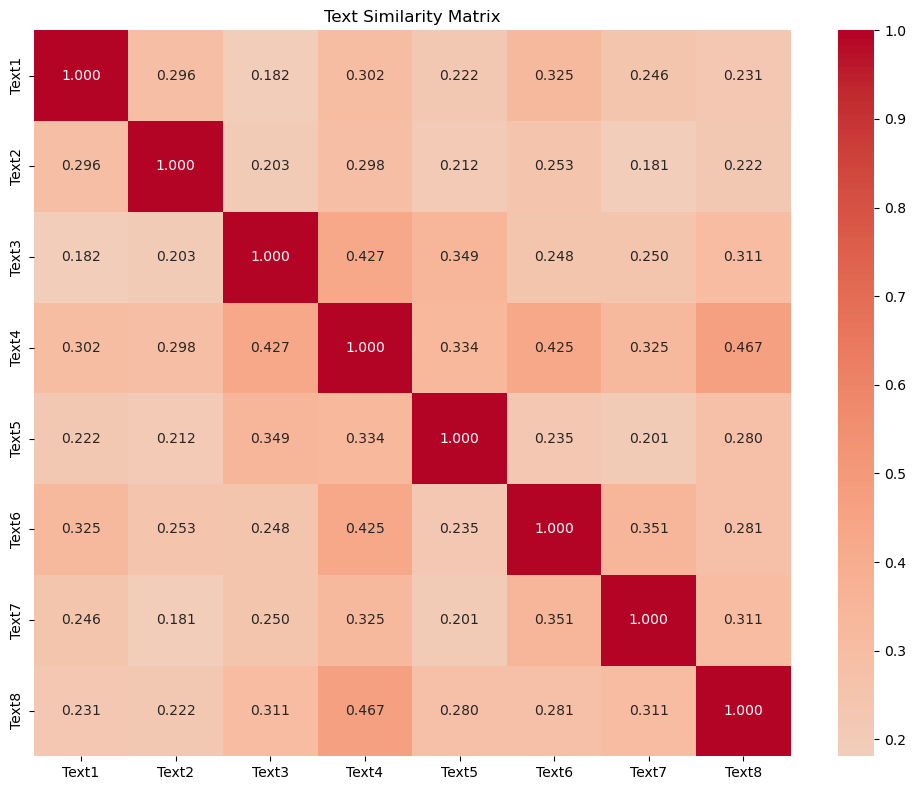


Text Similarity Matrix:
Text1: 今天天气很好，阳光明媚
Text2: 天空很晴朗，适合外出
Text3: 我喜欢机器学习
Text4: 深度学习非常有趣
Text5: 人工智能正在改变世界
Text6: 苹果的味道很好
Text7: 水果富含营养
Text8: 编程是一门艺术



In [27]:
# Chinese 
texts = [
    "今天天气很好，阳光明媚",                # 天气类
    "天空很晴朗，适合外出",                  # 天气类
    "我喜欢机器学习",                      # 科技类
    "深度学习非常有趣",                    # 科技类
    "人工智能正在改变世界",                # 科技类
    "苹果的味道很好",                      # 食物类
    "水果富含营养",                        # 食物类
    "编程是一门艺术"                       # 技术哲学类
]

demo_similarity_matrix(texts=texts)

Similarity Matrix Visualization Demo


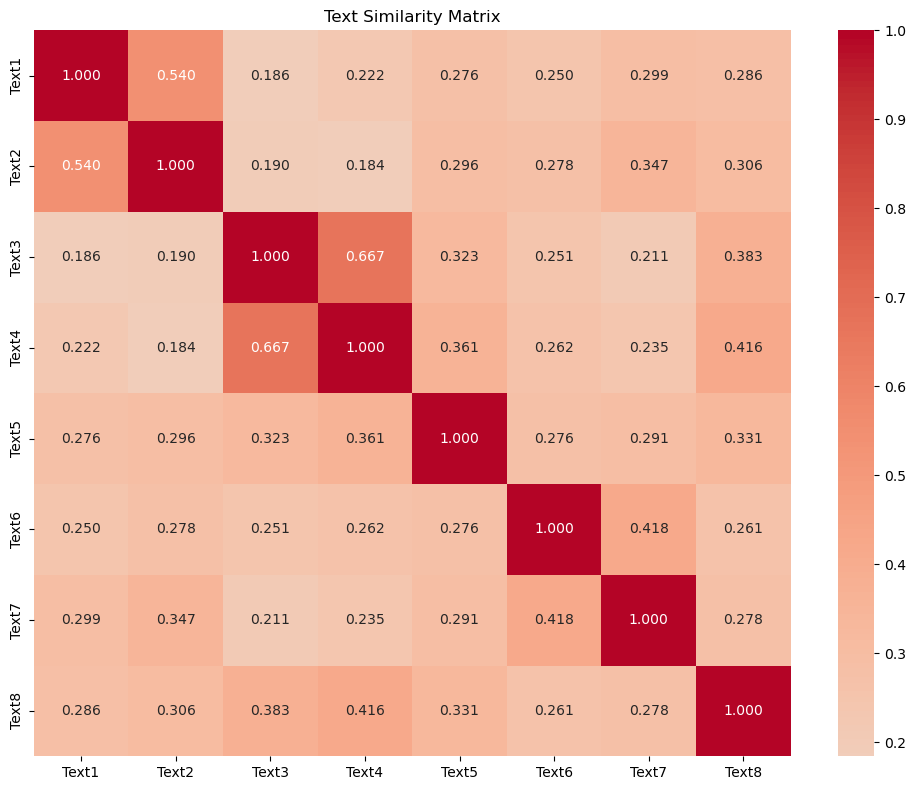


Text Similarity Matrix:
Text1: 今天天气晴朗，阳光明媚
Text2: 今天是个大晴天，气温很舒服
Text3: 我喜欢研究机器学习算法
Text4: 深度学习是一种常见的人工智能方法
Text5: 人工智能技术正在飞速发展
Text6: 苹果是一种常见的健康水果
Text7: 水果富含营养，有助于身体健康
Text8: 我觉得编程是一种创造力的表达



In [28]:
# Chinese demo 2
texts = [
    # 天气类
    "今天天气晴朗，阳光明媚",
    "今天是个大晴天，气温很舒服",

    # 科技类
    "我喜欢研究机器学习算法",
    "深度学习是一种常见的人工智能方法",
    "人工智能技术正在飞速发展",

    # 食物类
    "苹果是一种常见的健康水果",
    "水果富含营养，有助于身体健康",

    # 编程类
    "我觉得编程是一种创造力的表达"
]

demo_similarity_matrix(texts=texts)

## Semantic Search Demostration

In [23]:
def demo_semantic_search(documents=None, queries=None):
    """Semantic search demonstration"""
    print("=" * 60)
    print("Semantic Search Demo")
    print("=" * 60)
    
    demo = LocalEmbeddingDemo()
    
    # Document library
    if documents is None:
        documents = [
            "Machine learning is a branch of artificial intelligence that focuses on algorithms and statistical models",
            "Deep learning uses neural networks to simulate how the human brain works",
            "Natural language processing helps computers understand and generate human language",
            "Computer vision enables machines to interpret and understand digital images",
            "The weather is nice today, perfect for taking a walk outside",
            "Apples are nutritious fruits rich in vitamins",
            "Programming is the art of problem-solving that requires logical thinking and creativity",
            "Data science combines statistics, programming, and domain knowledge"
        ]
    
    # Query examples
    if queries is None:
        queries = [
            "What is artificial intelligence?",
            "What's good to do today?",
            "Nutritional value of fruits",
            "How to learn programming?"
        ]
    
    for query in queries:
        print(f"\nQuery: {query}")
        results = demo.semantic_search(query, documents, top_k=3)
        print("Most relevant documents:")
        for i, (doc, score) in enumerate(results, 1):
            print(f"{i}. (Similarity: {score:.4f}) {doc}")
        print("-" * 60)

In [14]:
demo_semantic_search()

Semantic Search Demo

Query: What is artificial intelligence?
Most relevant documents:
1. (Similarity: 0.3939) Natural language processing helps computers understand and generate human language
2. (Similarity: 0.3252) Deep learning uses neural networks to simulate how the human brain works
3. (Similarity: 0.3088) Machine learning is a branch of artificial intelligence that focuses on algorithms and statistical models
------------------------------------------------------------

Query: What's good to do today?
Most relevant documents:
1. (Similarity: 0.4346) The weather is nice today, perfect for taking a walk outside
2. (Similarity: 0.2592) Deep learning uses neural networks to simulate how the human brain works
3. (Similarity: 0.2189) Programming is the art of problem-solving that requires logical thinking and creativity
------------------------------------------------------------

Query: Nutritional value of fruits
Most relevant documents:
1. (Similarity: 0.5313) Apples are nutritiou

In [24]:
# Chinese demo
documents = [
    "机器学习是人工智能的一个分支，注重算法和统计模型",
    "深度学习利用神经网络模拟人脑的工作方式",
    "自然语言处理帮助计算机理解和生成人的语言",
    "计算机视觉让机器能够识别和理解图像",
    "今天天气很好，适合出去散步",
    "苹果是一种富含维生素的营养水果",
    "编程是一种需要逻辑思维和创造力的问题解决艺术",
    "数据科学结合了统计学、编程和领域知识"
]

queries = [
    "什么是人工智能？",
    "今天适合做什么？",
    "水果的营养价值有哪些？",
    "如何学好编程？"
]

demo_semantic_search(documents=documents, queries=queries)

Semantic Search Demo

Query: 什么是人工智能？
Most relevant documents:
1. (Similarity: 0.4224) 深度学习利用神经网络模拟人脑的工作方式
2. (Similarity: 0.4095) 自然语言处理帮助计算机理解和生成人的语言
3. (Similarity: 0.3959) 机器学习是人工智能的一个分支，注重算法和统计模型
------------------------------------------------------------

Query: 今天适合做什么？
Most relevant documents:
1. (Similarity: 0.4020) 今天天气很好，适合出去散步
2. (Similarity: 0.3279) 深度学习利用神经网络模拟人脑的工作方式
3. (Similarity: 0.3016) 计算机视觉让机器能够识别和理解图像
------------------------------------------------------------

Query: 水果的营养价值有哪些？
Most relevant documents:
1. (Similarity: 0.5463) 苹果是一种富含维生素的营养水果
2. (Similarity: 0.2142) 计算机视觉让机器能够识别和理解图像
3. (Similarity: 0.1998) 今天天气很好，适合出去散步
------------------------------------------------------------

Query: 如何学好编程？
Most relevant documents:
1. (Similarity: 0.3251) 深度学习利用神经网络模拟人脑的工作方式
2. (Similarity: 0.3120) 计算机视觉让机器能够识别和理解图像
3. (Similarity: 0.3072) 数据科学结合了统计学、编程和领域知识
------------------------------------------------------------


## 2D Visualization Demonstration

In [17]:
def demo_2d_visualization(texts = None):
    """2D visualization demonstration"""
    print("=" * 60)
    print("Embedding 2D Visualization Demo")
    print("=" * 60)
    
    demo = LocalEmbeddingDemo()
    
    # Different category texts
    if texts is None:
        texts = [
            # Weather category
            "The weather is nice today",
            "It's a sunny day",
            "It's raining outside",
            
            # Technology category
            "Machine learning is interesting",
            "Deep learning algorithms",
            "Artificial intelligence development",
            
            # Food category
            "Apples taste good",
            "Fruits are nutritious",
            "I like eating bananas",
            
            # Sports category
            "I like running",
            "Swimming is good exercise",
            "The basketball game is exciting"
        ]
    
    demo.visualize_embeddings_2d(texts)

Embedding 2D Visualization Demo
1: The weather is nice today
2: It's a sunny day
3: It's raining outside
4: Machine learning is interesting
5: Deep learning algorithms
6: Artificial intelligence development
7: Apples taste good
8: Fruits are nutritious
9: I like eating bananas
10: I like running
11: Swimming is good exercise
12: The basketball game is exciting


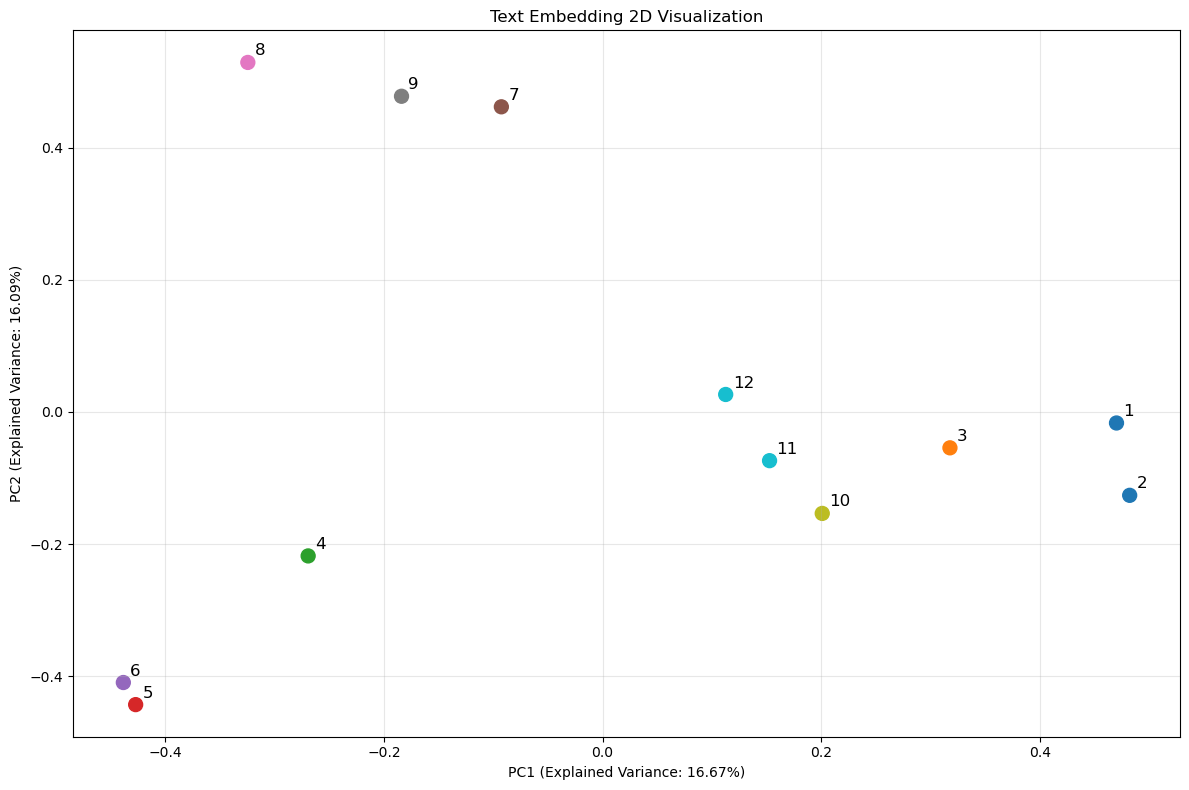

In [18]:
# English demo
demo_2d_visualization()

Embedding 2D Visualization Demo
1: 今天天气很好
2: 阳光明媚，适合出游
3: 外面正在下雨
4: 人工智能正在改变世界
5: 深度学习是一种强大的工具
6: 机器学习可以用于数据分析
7: 我喜欢吃苹果
8: 水果对身体有益
9: 香蕉的味道很香
10: 我每天早上去跑步
11: 游泳是一项全身运动
12: 篮球运动可以增强体质


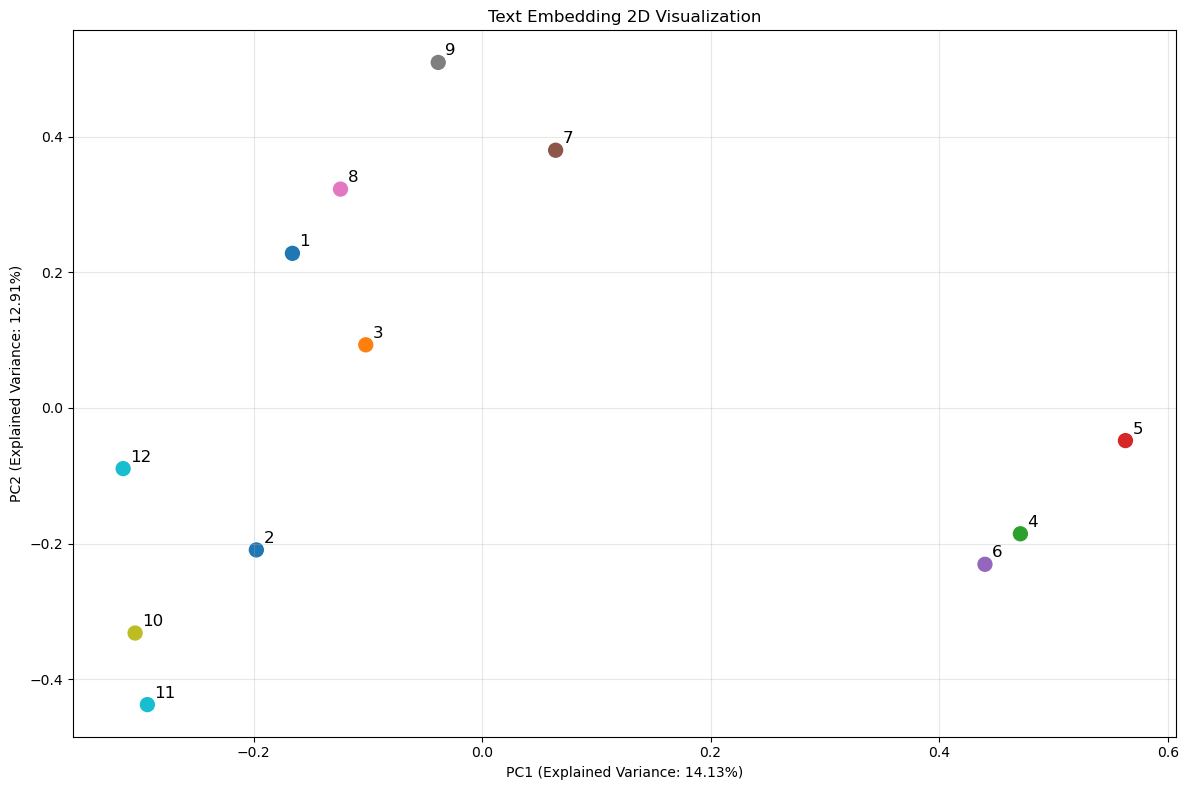

In [22]:
# Chinese demo
texts = [
    # 天气类
    "今天天气很好",
    "阳光明媚，适合出游",
    "外面正在下雨",

    # 科技类
    "人工智能正在改变世界",
    "深度学习是一种强大的工具",
    "机器学习可以用于数据分析",

    # 食物类
    "我喜欢吃苹果",
    "水果对身体有益",
    "香蕉的味道很香",

    # 运动类
    "我每天早上去跑步",
    "游泳是一项全身运动",
    "篮球运动可以增强体质"
]

demo_2d_visualization(texts=texts)